# Imports


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [5]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [7]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


# Loading Training Data

In [8]:
# Load data from CSV files
file_paths = [
                'cleaned_scored_reviews_tt0111161.csv',
                'cleaned_scored_reviews_tt0468569.csv',
                'cleaned_scored_reviews_tt15398776.csv'
             ]
dfs = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dfs, ignore_index=True)
df = df[df['Review'].notna()]
df = df[df['Sentiment_Score'].notna()]

# Splitting into Train-Test Datasets

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = df['Review'].values
y = df['Polarity'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# Create DataFrames for train and test data
train_dataset = pd.DataFrame({'Review': X_train, 'Polarity': y_train})
test_dataset = pd.DataFrame({'Review': X_test, 'Polarity': y_test})

# Convert DataFrames to Hugging Face Datasets
train_data = datasets.Dataset.from_pandas(train_dataset)
test_data = datasets.Dataset.from_pandas(test_dataset)

# Print the datasets to verify
print("Train Dataset:")
print(train_data)
print("\nTest Dataset:")
print(test_data)

Train Dataset:
Dataset({
    features: ['Review', 'Polarity'],
    num_rows: 14441
})

Test Dataset:
Dataset({
    features: ['Review', 'Polarity'],
    num_rows: 9628
})


In [10]:
from torchtext.data import get_tokenizer

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [11]:
tokenizer = get_tokenizer("basic_english")

def tokenize_example(dataset, tokenizer, max_length):
    tokens = tokenizer(dataset['Review'])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [12]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/14441 [00:00<?, ? examples/s]

Map:   0%|          | 0/9628 [00:00<?, ? examples/s]

In [13]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [14]:
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [15]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [16]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [17]:
vocab.set_default_index(unk_index)

In [18]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [19]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/10830 [00:00<?, ? examples/s]

Map:   0%|          | 0/3611 [00:00<?, ? examples/s]

Map:   0%|          | 0/9628 [00:00<?, ? examples/s]

In [20]:
train_data

Dataset({
    features: ['Review', 'Polarity', 'tokens', 'length', 'ids'],
    num_rows: 10830
})

In [21]:
train_data = train_data.with_format(type="torch", columns=["ids", "Polarity", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "Polarity", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "Polarity", "length"])

In [22]:
train_data[0]

{'Polarity': tensor(1),
 'length': tensor(94),
 'ids': tensor([  25,    5,   46,    0,    2,   96,    4,    2,   12,   19,   54,   22,
         3733,    2,  327,    3,   67,   19,   65,    2, 1100,    2,  608,    0,
         4374,  376,   11,  128,  269,   25,    5,   12,  205,  125,  129,   81,
           25,    5,  676,   39,    6, 6879,    2, 4107,    0,    3,    5,  318,
          184,   33,    5,  390,   87,  368,  136,   41,    6,  794,   21,  258,
           18,   67, 2022,  376,   25,  373,  215,   91,   33,  156,  133,  123,
          117,    3,  876,  910,  186,   62,   25,    5,  384,   12,   34,   17,
          162,    9,   52,   29, 2633,   11, 3075, 1372, 2764, 1782])}

In [23]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["Polarity"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "Polarity": batch_label}
        return batch

    return collate_fn

In [24]:
from torch.utils.data import DataLoader
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [25]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [26]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [27]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("Polarity"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,283,802 trainable parameters


In [29]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [30]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(8910, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
vectors = torchtext.vocab.GloVe()

In [32]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [33]:
model.embedding.weight.data = pretrained_embedding

In [34]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [37]:
model = model.to(device)
criterion = criterion.to(device)

In [35]:
def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["Polarity"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision, recall, f1 = get_metrics(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [42]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["Polarity"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision, recall, f1 = get_metrics(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            epoch_precisions.append(precision)
            epoch_recalls.append(recall)
            epoch_f1s.append(f1)
    return np.mean(epoch_losses), np.mean(epoch_accs), np.mean(epoch_precisions), np.mean(epoch_recalls), np.mean(epoch_f1s)

In [43]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [44]:
from sklearn.metrics import precision_recall_fscore_support
def get_metrics(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    true_classes = label.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    return precision, recall, f1

In [ ]:
n_epochs = 5
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc, train_precision, train_recall, train_f1 = train_model(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["train_precisions"].append(train_precision)
    metrics["train_recalls"].append(train_recall)
    metrics["train_f1s"].append(train_f1)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["valid_precisions"].append(valid_precision)
    metrics["valid_recalls"].append(valid_recall)
    metrics["valid_f1s"].append(valid_f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    # print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    # print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, train_precision: {train_precision:.3f}, train_recall: {train_recall:.3f}, train_f1: {train_f1:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}, valid_precision: {valid_precision:.3f}, valid_recall: {valid_recall:.3f}, valid_f1: {valid_f1:.3f}")

training...:   0%|          | 0/22 [00:00<?, ?it/s]

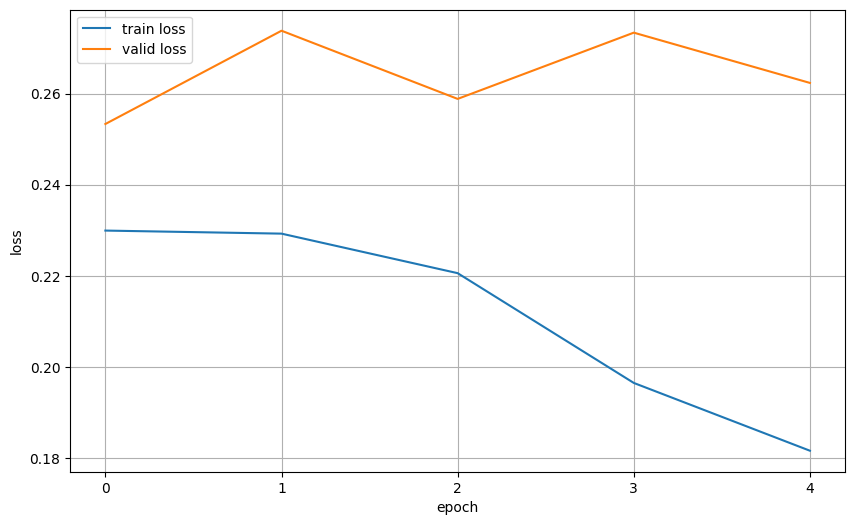

In [61]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

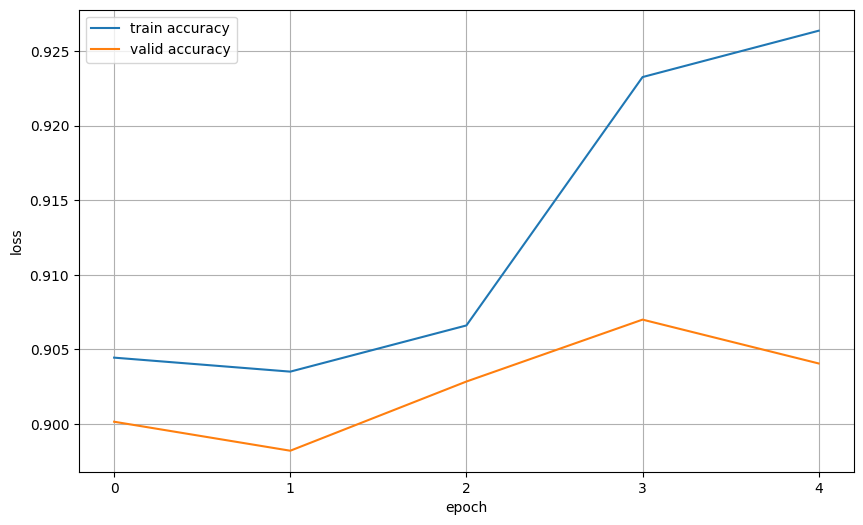

In [62]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [46]:
model.load_state_dict(torch.load("lstm.pt", map_location=torch.device('cpu')))

train_loss, train_acc, train_precision, train_recall, train_f1 = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 19/19 [04:06<00:00, 12.96s/it]


In [ ]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

In [47]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    if(predicted_class == 1):
        return predicted_class, predicted_probability
    else:
        return predicted_class, -predicted_probability

In [48]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, -0.8314508199691772)

In [49]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.8563315272331238)

In [50]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, -0.6217565536499023)

# Testing on Dataset

In [53]:
plot_df = pd.read_csv('cleaned_scored_reviews_tt0455944.csv')

plot_df = plot_df[plot_df['Review'].notna()]
plot_df = plot_df[plot_df['Sentiment_Score'].notna()]

print(plot_df.head)

<bound method NDFrame.head of                                                  Title           Author  \
0                                   May the Blood Flow     Tweetienator   
1    Denzel Washington made this film better than i...  Top_Dawg_Critic   
2                                      Denzel nails it   Leofwine_draca   
3                 A Stylish And Daring Action Thriller          CalRhys   
4    Gruesome at times, The Equalizer is a rewardin...       LloydBayer   
..                                                 ...              ...   
771                                we are magpies now?    destinedsleep   
772     I liked this until he pulls out a Hilti DX 351    blackriverrt3   
773                  Quintessential Denzel Washington!            m1965   
774                      Silent, brooding and Kick-ass        Asurasura   
775                                    What about Bob?            sesht   

                  Date  Stars(out_of_10)  \
0          6 June 2019   

In [54]:
# Predict sentiment scores for all reviews
plot_df['Predicted_Polarity'] = plot_df['Review'].apply(lambda x: predict_sentiment(x, model, tokenizer, vocab, device)[0])
plot_df['Predicted_Sentiment_Score'] = plot_df['Review'].apply(lambda x: predict_sentiment(x, model, tokenizer, vocab, device)[1])



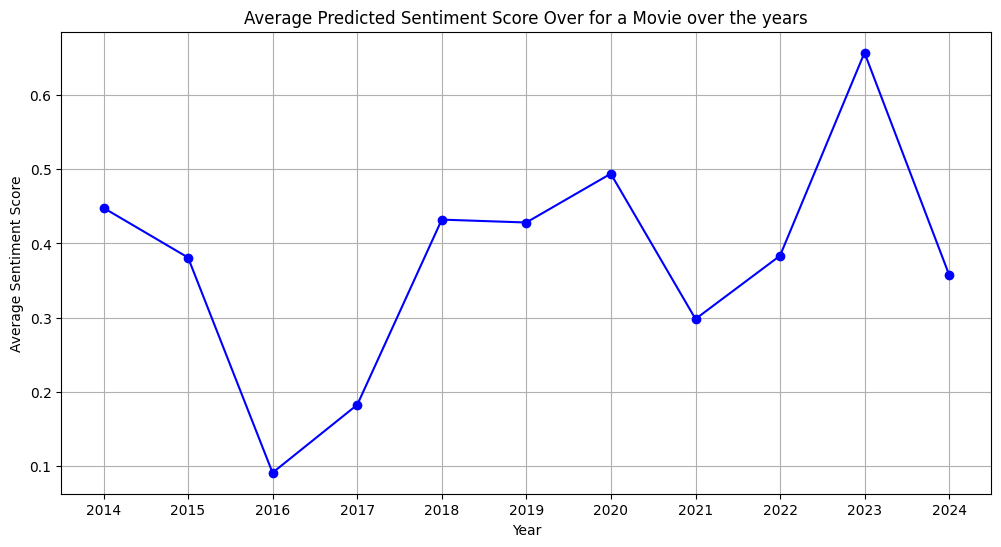

In [75]:
# Convert the 'Date' column to datetime format
plot_df['Date'] = pd.to_datetime(plot_df['Date'], format='%d %B %Y')

# Sort the dataframe by date
plot_df = plot_df.sort_values('Date')

# Extract year and month from the date
plot_df['YearMonth'] = plot_df['Date'].dt.to_period('Y')

# Calculate the average predicted probability for each month
monthly_avg = plot_df.groupby('YearMonth')['Predicted_Sentiment_Score'].mean().reset_index()
monthly_avg2 = plot_df.groupby('YearMonth')['Sentiment_Score'].mean().reset_index()

# Convert the 'YearMonth' column back to datetime for plotting
monthly_avg['YearMonth'] = monthly_avg['YearMonth'].dt.to_timestamp()
monthly_avg2['YearMonth'] = monthly_avg2['YearMonth'].dt.to_timestamp()

# Plot the average predicted sentiment scores for each month
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['YearMonth'], monthly_avg['Predicted_Sentiment_Score'], marker='o', linestyle='-', color='b')
# plt.plot(monthly_avg2['YearMonth'], monthly_avg2['Sentiment_Score'], marker='s', linestyle='-', color='g')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Predicted Sentiment Score Over for a Movie over the years')
plt.grid(True)
plt.show()

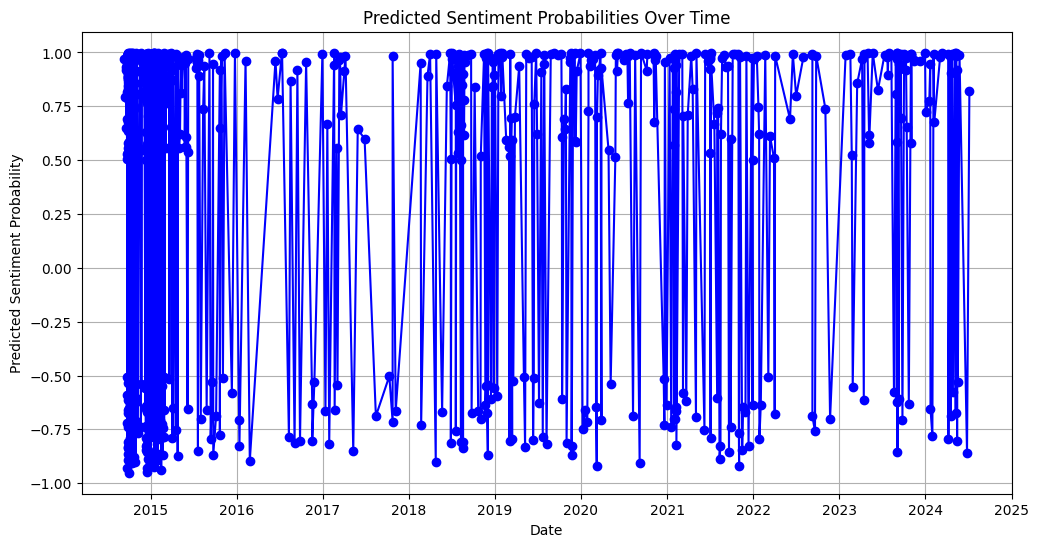

In [57]:
# Plot the predicted sentiment scores over time
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Predicted_Sentiment_Score'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Predicted Sentiment Probability')
plt.title('Predicted Sentiment Probabilities Over Time')
plt.grid(True)
plt.show()